In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from scipy.io import wavfile
from scipy.signal import correlate, firls, remez, freqz
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import sobel

In [4]:
# Referenced https://fairyonice.github.io/implement-the-spectrogram-from-scratch-in-python.html because there was nothing in the slides on how to actually do this and my notes weren't detailed enough to be sufficient
corc = wavfile.read('/content/gdrive/MyDrive/Cornell-Tech-Github/Digital-Signal-Processing/Corcovado.wav')[1][:,0]
def create_spectrogram(ts,NFFT,noverlap = None):
    '''
          ts: original time series
        NFFT: The number of data points used in each block for the DFT.
          Fs: the number of points sampled per second, so called sample_rate
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    if noverlap is None:
        noverlap = NFFT/2
    noverlap = int(noverlap)
    starts  = np.arange(0,len(ts),NFFT-noverlap,dtype=int)
    # remove any window with less than NFFT sample size
    starts  = starts[starts + NFFT < len(ts)]
    xns = []
    for start in starts:
        # short term discrete fourier transform
        ts_window = get_xns(ts[start:start + NFFT]) 
        xns.append(ts_window)
    specX = np.array(xns).T
    # rescale the absolute value of the spectrogram as rescaling is standard
    spec = 10*np.log10(specX)
    assert spec.shape[1] == len(starts) 
    return(starts,spec)
def get_xn(Xs,n):
    '''
    calculate the Fourier coefficient X_n of 
    Discrete Fourier Transform (DFT)
    '''
    L  = len(Xs)
    ks = np.arange(0,L,1)
    xn = np.sum(Xs*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

def get_xns(ts):
    '''
    Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2
    and multiply the absolute value of the Fourier coefficients by 2, 
    to account for the symetry of the Fourier coefficients above the Nyquest Limit. 
    '''
    mag = []
    L = len(ts)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(ts,n))*2)
    return(mag)

L = 1024
noverlap = 50
starts, spec = create_spectrogram(corc[:4096000], L, noverlap = noverlap)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


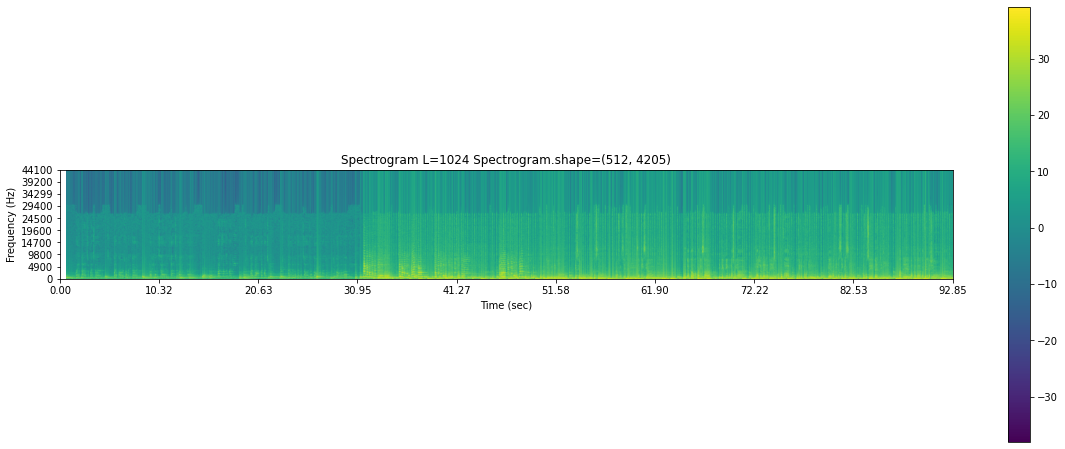

In [5]:
def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz )
    
def plot_spectrogram(spec,sample_rate, L, starts, mappable = None):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec,origin='lower')

    ## create ylim
    Nyticks = 10
    ks      = np.linspace(0,spec.shape[0],Nyticks)
    ksHz    = get_Hz_scale_vec(ks,sample_rate,len(spec))
    plt.yticks(ks,ksHz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    Nxticks = 10
    ts_spec = np.linspace(0,spec.shape[1],Nxticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,len(spec)/sample_rate*starts[-1]/len(spec),Nxticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L={} Spectrogram.shape={}".format(L,spec.shape))
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)
plot_spectrogram(spec,44100,L, starts)

In [6]:
def fir(N, L, w, H):
  A = np.zeros((len(w), L // 2 + 1))
  for x in range(len(w)):
    for y in range(L // 2 + 1):
      if y == 0:
        A[x, y] = 1
      else:
        A[x, y] = 2 * np.cos(w[x] * y)
  return np.linalg.pinv(A.T @ A) @ A.T @ H.reshape(-1, 1)

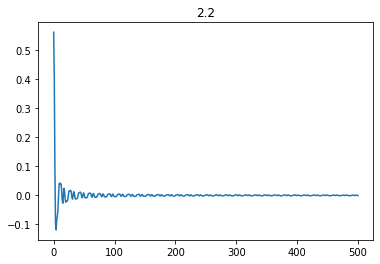

In [30]:
w = np.linspace(0, np.pi, 1000)
As = np.zeros(w.shape)
for i in range(len(w)):
  if w[i] >= 0 and w[i] < np.pi/8:
    As[i] = 1
  if w[i] >= np.pi/8 and w[i] < np.pi/4:
    As[i] = 2
  if w[i] >= np.pi/4 and w[i] < 3*np.pi/8:
    As[i] = 1
  if w[i] >= 3*np.pi/8 and w[i] < np.pi/2:
    As[i] = 0.5
h = fir(101, 1000, w, As)
plt.figure()
plt.title("2.2")
plt.plot(h)

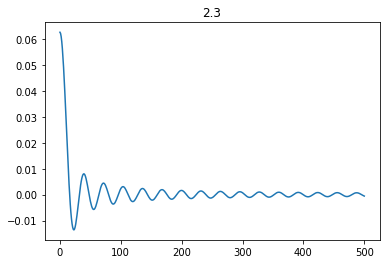

In [31]:
w = np.linspace(0, np.pi, 1000)
As = np.zeros(w.shape)
for i in range(len(w)):
  if w[i] >= 0 and w[i] < np.pi/16:
    As[i] = 1
h_lpf = fir(101, 1000, w, As)
plt.figure()
plt.title("2.3")
plt.plot(h_lpf)

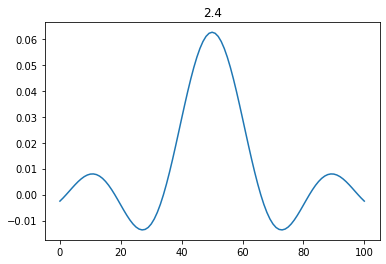

In [28]:
w = np.linspace(0, np.pi, 1000)
As = np.zeros(w.shape)
for i in range(len(w)):
  if w[i] >= 0 and w[i] < np.pi/16:
    As[i] = 1
h_firls = firls(101, w, As, nyq=np.pi)
plt.figure()
plt.title("2.4")
plt.plot(h_firls)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


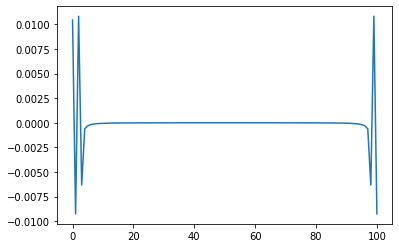

In [29]:
plt.figure()
plt.plot(np.fft.ifft(h_firls))

In [ ]:
corc = wavfile.read('/content/gdrive/MyDrive/Cornell-Tech-Github/Digital-Signal-Processing/Corcovado.wav')[1][:,0]
corc_conv = np.convolve(np.fft.ifft(h_lpf)[:,0], corc)
plt.figure()
plt.plot(corc_conv)
from IPython.display import Audio 
from IPython.core.display import display
display(Audio(corc_conv, autoplay=True, rate=44100))


Output hidden; open in https://colab.research.google.com to view.

It sounds a bit muffled compared to the original, perhaps the low pass filter got rid of the more animated sounds.

In [ ]:
w = np.linspace(0, np.pi, 1000)
As = np.zeros(w.shape)
for i in range(len(w)):
  if w[i] >= 0 and w[i] < np.pi/16:
    As[i] = 1
h_firls = firls(101, w, As, nyq=np.pi)
plt.figure()
plt.plot(h_firls)
plt.figure()
plt.plot(np.fft.ifft(h_firls))

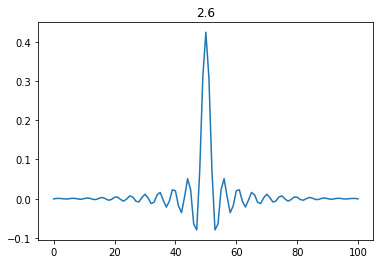

In [12]:
w = np.linspace(0, np.pi, len(corc))
fs = 1
h_remez = remez(101, [0, np.pi/16, np.pi/16 + np.pi/100, 0.5*fs],
                    [1, 0], Hz=fs)
plt.figure()
plt.title("2.6")
plt.plot(h_remez)

In [ ]:
corc_conv2 = np.convolve(np.fft.ifft(h_remez), corc)
plt.figure()
plt.plot(corc_conv2)
from IPython.display import Audio 
from IPython.core.display import display
display(Audio(corc_conv2, autoplay=True, rate=44100))

Output hidden; open in https://colab.research.google.com to view.

The magnitude of this signal is much lower than the last one.

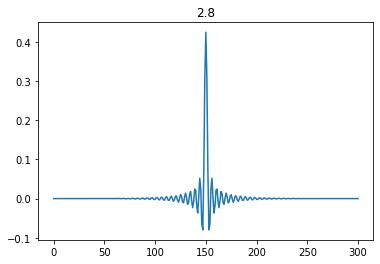

In [26]:
w = np.linspace(0, np.pi, len(corc))
fs = 1
h_remez_moretaps = remez(301, [0, np.pi/16, np.pi/16 + np.pi/100, 0.5*fs],
                    [1, 0], Hz=fs)
plt.figure()
plt.title("2.8")
plt.plot(h_remez_moretaps)
h_remez_bigtrans = remez(101, [0, np.pi/16, np.pi/16 + np.pi/25, 0.5*fs],
                    [1, 0], Hz=fs)

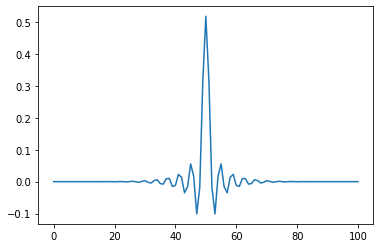

In [27]:
plt.figure()
plt.plot(h_remez_bigtrans)

2.8: As shown above, more taps does not really impact the magnitude but the frequency increases. With a larger transition band the frequency remains constant but the magnitude slightly increases.
2.9: The bass goes hard though

In [14]:
def random_mask(image, f):
  mask = np.random.choice([0,1], image.shape, p=[f/100, 1-f/100])
  return mask * image, mask

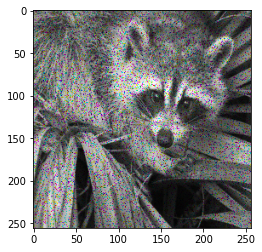

In [15]:
x = cv2.imread('/content/gdrive/MyDrive/Cornell-Tech-Github/Digital-Signal-Processing/Files/X.png')
y = cv2.imread('/content/gdrive/MyDrive/Cornell-Tech-Github/Digital-Signal-Processing/Files/Y.png')

x_tild, m = random_mask(x, 10)
plt.imshow(x_tild)
plt.show()

In [16]:
def image_grad(img):
  # Get x-gradient in "sx"
  sx = sobel(img,axis=0,mode='constant')
  # Get y-gradient in "sy"
  sy = sobel(img,axis=1,mode='constant')
  # Get square root of sum of squares
  s=np.hypot(np.abs(sx),np.abs(sy))
  return s.astype(np.int32)

In [17]:
def recon_loss(input, masked, mask, lamb):
  return np.sum((mask * input - masked) ** 2) + lamb * np.sum(image_grad(input))

In [18]:
def image_merge(a, b, alpha):
  return alpha * a + (1 - alpha) * b

In [19]:
def masked_image_merge(a, b, mask, alpha):
  return mask * a + (1 - mask) * image_merge(a, b, alpha)

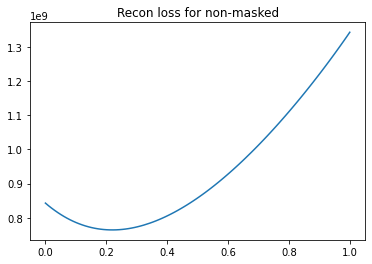

In [22]:
alphas = np.linspace(0, 1, 100)
rl = []
rlm = []
min = 1e10
output1, output2 = x, x
for alpha in alphas:
  _, mask = random_mask(x, 100 * alpha)
  merged = image_merge(x, y, alpha)
  masked_merged = masked_image_merge(x, y, random_mask(x, 100 * alpha)[1], alpha)
  rl_current = recon_loss(merged, mask * merged, mask, 20)
  rlm_current = recon_loss(masked_merged, mask * masked_merged, mask, 20)
  rl.append(rl_current)
  rlm.append(rlm_current)
  if min == -1 or rl_current < min:
    output1, output2 = merged, mask * merged
    min = rl_current
  if rlm_current < min:
    output1, output2 = masked_merged, mask * masked_merged
    min = rlm_current
plt.figure()
plt.title("Recon loss for non-masked")
plt.plot(alphas, rl)

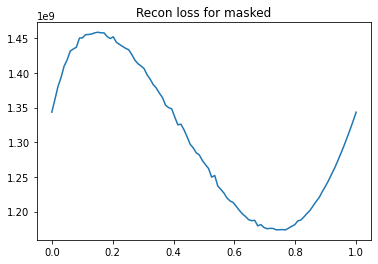

In [23]:
plt.figure()
plt.title("Recon loss for masked")
plt.plot(alphas, rlm)

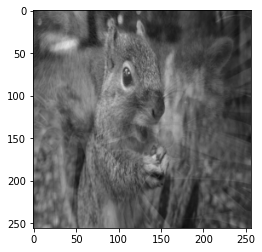

In [24]:
plt.imshow(output1.astype(np.int32))
plt.show()

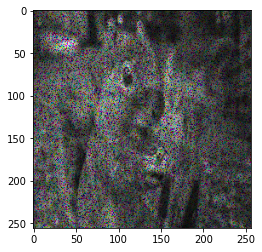

In [25]:
plt.imshow(output2.astype(np.int32))
plt.show()

The output has some salt and pepper like noise with some random black splotches but the overall picture is still clear and the original image is easy to identify.